# 網路入侵偵測：異常偵測實戰

本教學將以 KDD Cup 99 網路入侵資料集為例，整合前述異常偵測技術，實作一個完整的入侵偵測流程。你將學會：

- 了解 KDD Cup 99 資料集的特徵結構與應用背景
- 進行資料前處理、特徵選擇與降維視覺化
- 應用 Isolation Forest 及 AutoEncoder 進行異常偵測
- 評估模型效能並解讀結果

本章為本課程的綜合實作，請搭配前幾章所學理論與技巧一同練習。

**參考資料：**

- [Isolation Forest 原理與應用](https://cs.nju.edu.cn/zhouzh/zhouzh.files/publication/icdm08b.pdf)
- [AutoEncoder for Anomaly Detection (pyod)](https://pyod.readthedocs.io/en/latest/pyod.models.html#auto-encoder)
- [KDD Cup 99 Dataset](http://kdd.ics.uci.edu/databases/kddcup99/kddcup99.html)

---

## 1. 載入並探索資料集

**資料集用途：**
KDD Cup 99 資料集是第三屆國際知識發現與資料採礦工具競賽的標準資料集，目標是建立網路入侵偵測器，能區分「惡意連線」（入侵/攻擊）和「正常連線」。

**資料特徵：**
包含軍事網路環境中模擬的多種入侵攻擊類型
提供標準化的審計資料供研究人員使用
包含多樣化的連線紀錄樣本

**應用意義：**
該資料集被廣泛用於異常偵測、機器學習和網路安全研究，是評估入侵偵測演算法效能的業界標準基準。

In [1]:
## 載入並探索資料集
import pandas as pd

# 讀取 CSV 檔案
data = pd.read_csv('text-book/kddcup.data.corrected.csv')

print("=== 數據集基本信息 ===")
print(f"數據形狀: {data.shape}")
print(f"特徵數量: {data.shape[1]}")
print(f"樣本數量: {data.shape[0]}")

# 顯示前 20 筆資料
print("\n=== 數據前 20 行 ===")
data.head(20)

=== 數據集基本信息 ===
數據形狀: (4898431, 42)
特徵數量: 42
樣本數量: 4898431

=== 數據前 20 行 ===


,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label
0,0,tcp,http,SF,215,45076,0,0,0,0,...,0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,normal.
1,0,tcp,http,SF,162,4528,0,0,0,0,...,1,1.0,0.0,1.00,0.0,0.0,0.0,0.0,0.0,normal.
2,0,tcp,http,SF,236,1228,0,0,0,0,...,2,1.0,0.0,0.50,0.0,0.0,0.0,0.0,0.0,normal.
3,0,tcp,http,SF,233,2032,0,0,0,0,...,3,1.0,0.0,0.33,0.0,0.0,0.0,0.0,0.0,normal.
4,0,tcp,http,SF,239,486,0,0,0,0,...,4,1.0,0.0,0.25,0.0,0.0,0.0,0.0,0.0,normal.
5,0,tcp,http,SF,238,1282,0,0,0,0,...,5,1.0,0.0,0.20,0.0,0.0,0.0,0.0,0.0,normal.
6,0,tcp,http,SF,235,1337,0,0,0,0,...,6,1.0,0.0,0.17,0.0,0.0,0.0,0.0,0.0,normal.
7,0,tcp,http,SF,234,1364,0,0,0,0,...,7,1.0,0.0,0.14,0.0,0.0,0.0,0.0,0.0,normal.
8,0,tcp,http,SF,239,1295,0,0,0,0,...,8,1.0,0.0,0.12,0.0,0.0,0.0,0.0,0.0,normal.
9,0,tcp,http,SF,181,5450,0,0,0,0,...,9,1.0,0.0,0.11,0.0,0.0,0.0,0.0,0.0,normal.


### KDD Cup 99 資料集欄位定義與背景

KDD Cup 99 是經典的網路入侵偵測資料集，廣泛用於異常偵測與資安研究。每筆連線紀錄包含多種特徵，分為三大類：

#### (1) 基本連線特徵
- 連線時間、協定、服務、狀態、資料量等
#### (2) 內容特徵
- 登入狀態、檔案操作、root 權限、熱指標等
#### (3) 流量特徵
- 連線頻率、錯誤率、同主機/服務比例等

這些特徵有助於區分正常連線與各類型攻擊（如 DOS、R2L、U2R、Probe），支援各種入侵偵測模型的訓練與分析。

---

In [2]:
# 檢查是否有缺失值
print("\n=== 缺失值檢查 ===")
missing_values = data.isnull().sum()
if missing_values.sum() > 0:
    print(missing_values[missing_values > 0])
else:
    print("無缺失值")



=== 缺失值檢查 ===
無缺失值


In [3]:
# 去重
data = data.drop_duplicates()

In [4]:
# 檢查是否有非數值型別的特徵
non_numeric_features = data.select_dtypes(exclude=['number']).columns
print("\n=== 非數值型別特徵 ===")
print(non_numeric_features)



=== 非數值型別特徵 ===
Index(['protocol_type', 'service', 'flag', 'label'], dtype='object')


In [5]:
# 其中 label 欄位表示連線是否異常，除了 normal 以外，包含以下類型：
# back,buffer_overflow,ftp_write,guess_passwd,imap,ipsweep,land,loadmodule,multihop,neptune,nmap,
# perl,phf,pod,portsweep,rootkit,satan,smurf,spy,teardrop,warezclient,warezmaster.
# 其中 normal 約 9M 筆，其他攻擊類型約 39M 筆。
print("\n=== 正常與異常連線數量 ===")
print(data['label'].value_counts())


=== 正常與異常連線數量 ===
label
normal.             812814
neptune.            242149
satan.                5019
ipsweep.              3723
portsweep.            3564
smurf.                3007
nmap.                 1554
back.                  968
teardrop.              918
warezclient.           893
pod.                   206
guess_passwd.           53
buffer_overflow.        30
warezmaster.            20
land.                   19
imap.                   12
rootkit.                10
loadmodule.              9
ftp_write.               8
multihop.                7
phf.                     4
perl.                    3
spy.                     2
Name: count, dtype: int64


---

## 2. 數據型態轉換

### 資料型態轉換與標籤處理

為了讓異常偵測模型能正確辨識攻擊行為，需將原始標籤（label）轉換為`二元分類`：
- `normal.` → 0（正常）
- 其他攻擊類型 → 1（異常）

此外，部分特徵為類別型資料（如協定、服務類型），需進行 `one-hot` 編碼或標籤編碼，將其轉為數值型態，才能輸入機器學習模型。這是異常偵測常見的前處理步驟。

#### One-hot 編碼會將每個類別轉為獨立欄位，適用於無序類別特徵。

**優點：**
* 沒有順序關係，適合無序類別
* 模型能正確理解類別之間是獨立的
* 適合大多數機器學習演算法

**缺點：**

* 會增加特徵維度（若類別數量多，維度會暴增）
* 記憶體使用較多
* 可能造成「維度災難」

#### 標籤編碼 (Label Encoding) 則將類別映射為整數，適用於有序類別特徵。

**優點：**
* 不增加特徵維度
* 記憶體使用較少
* 適合有順序關係的類別（如：低、中、高）

**缺點：**
* 引入了「順序關係」（0 < 1 < 2），但類別資料通常沒有大小關係
* 可能誤導模型認為類別之間有數值關聯

In [6]:
# 將 label 欄位轉換為二元標籤：normal 為 0，其他為 1
data['label'] = data['label'].apply(lambda x: 0 if x == 'normal.' else 1)

# 取得非數值型欄位，排除已經被轉換的欄位 label
non_numeric_features = [
  col for col in data.columns if data[col].dtype == 'object' and col != 'label'
]

# 執行 one-hot 編碼
data = pd.get_dummies(
  data,
  columns=non_numeric_features  # 指定要進行編碼的欄位列表
)

# # 或者使用 Label Encoding
# from sklearn.preprocessing import LabelEncoder

# label_encoders = {}
# for col in non_numeric_features:
#     le = LabelEncoder()
#     data[col] = le.fit_transform(data[col])
#     label_encoders[col] = le

print("\n=== 轉換後的數據前 20 行 ===")
data.head(20)


=== 轉換後的數據前 20 行 ===


,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,flag_REJ,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH
0,0,215,45076,0,0,0,0,0,1,0,...,False,False,False,False,False,False,False,False,True,False
1,0,162,4528,0,0,0,0,0,1,0,...,False,False,False,False,False,False,False,False,True,False
2,0,236,1228,0,0,0,0,0,1,0,...,False,False,False,False,False,False,False,False,True,False
3,0,233,2032,0,0,0,0,0,1,0,...,False,False,False,False,False,False,False,False,True,False
4,0,239,486,0,0,0,0,0,1,0,...,False,False,False,False,False,False,False,False,True,False
5,0,238,1282,0,0,0,0,0,1,0,...,False,False,False,False,False,False,False,False,True,False
6,0,235,1337,0,0,0,0,0,1,0,...,False,False,False,False,False,False,False,False,True,False
7,0,234,1364,0,0,0,0,0,1,0,...,False,False,False,False,False,False,False,False,True,False
8,0,239,1295,0,0,0,0,0,1,0,...,False,False,False,False,False,False,False,False,True,False
9,0,181,5450,0,0,0,0,0,1,0,...,False,False,False,False,False,False,False,False,True,False


In [7]:
print("\n=== 正常與異常連線數量 ===")
print(data['label'].value_counts())


=== 正常與異常連線數量 ===
label
0    812814
1    262178
Name: count, dtype: int64


In [8]:
# 從數據中挑選出 90% 的正常連線及 10% 的異常樣本作為實驗資料
n_normal = 90000
n_anomaly = 10000

normal_data = data[data['label'] == 0].sample(
  n=n_normal, random_state=42
)
anomaly_data = data[data['label'] == 1].sample(
  n=n_anomaly, random_state=42
)

# 將正常連線和異常連線資料合併，並進行隨機打亂，以準備用於模型訓練
experiment_data = pd.concat(
  [normal_data, anomaly_data]
).sample(frac=1, random_state=42).reset_index(drop=True)

print("\n=== 實驗資料正常與異常連線數量比例 ===")
print(experiment_data['label'].value_counts(normalize=True))


=== 實驗資料正常與異常連線數量比例 ===
label
0    0.9
1    0.1
Name: proportion, dtype: float64


---

## 3. 特徵選擇（Feature Selection）與資料分析

高維資料中，並非所有特徵都對異常偵測有幫助。本單元示範如何利用單變量統計方法（如 ANOVA F-value）進行特徵選擇，只保留最具區辨力的前 10% 特徵，這有助於提升模型效能並加速訓練。

ANOVA F-value（變異數分析 F 值）是一種統計方法，用來比較「不同群體」之間的差異是否顯著。

### 生活中的例子：三種減肥藥的效果

假設你測試了 A、B、C 三種減肥藥：

* 如果 F 值很高：說明這三種藥的效果真的不一樣（例如 A 藥特別有效）。
* 如果 F 值很低：說明雖然每個人瘦的程度不同，但那是因為每個人體質（組內雜訊）本來就不同，跟藥（組間差異）沒什麼關係。

### 特徵選擇：提升模型效能

**特徵選擇流程**
1. 將標籤（label）與特徵分開
2. 使用 SelectPercentile + f_classif，根據每個特徵與標籤的關聯性分數進行排序
3. 只保留分數最高的特徵進行後續建模

In [9]:
# Univariate feature selection
# from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.feature_selection import SelectPercentile, f_classif

# 分離特徵與標籤
X = experiment_data.drop('label', axis=1)
y = experiment_data['label']

# selector = SelectKBest(
#   score_func=f_classif,
#   k=5
# )
selector = SelectPercentile(
  score_func=f_classif, # 使用 ANOVA F-value 作為評分標準
  percentile=10         # 選取前 10% 的特徵
)
X_selected = selector.fit_transform(X, y)

# 取得被選取的特徵名稱
selected_features = X.columns[selector.get_support()]

print("\n=== 選取的特徵 ===")
print(selected_features)


=== 選取的特徵 ===
Index(['logged_in', 'count', 'serror_rate', 'srv_serror_rate', 'same_srv_rate',
       'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_serror_rate',
       'dst_host_srv_serror_rate', 'service_http', 'service_private',
       'flag_S0', 'flag_SF'],
      dtype='object')


/Users/jonas/.pyenv/versions/anomalyebook-3.11.11/lib/python3.11/site-packages/sklearn/feature_selection/_univariate_selection.py:111: UserWarning: Features [16 17 44 63 66 68 86] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/jonas/.pyenv/versions/anomalyebook-3.11.11/lib/python3.11/site-packages/sklearn/feature_selection/_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


In [10]:
# 只保留選取的特徵
experiment_data = experiment_data[selected_features.tolist() + ['label']]

---

## 4. 資料分割、標準化與降維視覺化

- 隨機分割訓練/測試集，確保模型泛化能力
- 標準化特徵，避免尺度差異影響模型
- 利用 PCA 進行 2D/3D 降維視覺化，觀察正常與異常樣本分布


In [11]:
# 將實驗資料隨機分為訓練集與測試集（80% 訓練，20% 測試）
from sklearn.model_selection import train_test_split

# 分離特徵與標籤
X = experiment_data.drop(columns=['label'])
y = experiment_data['label']

# 隨機分割訓練集與測試集，確保模型泛化能力
X_train, X_test, y_train, y_test = train_test_split(
  X, y,
  test_size=0.2,
  random_state=42
)

print("\n=== 訓練集與測試集大小 ===")
print(f"訓練集大小: {X_train.shape}, 測試集大小: {X_test.shape}")


=== 訓練集與測試集大小 ===
訓練集大小: (80000, 13), 測試集大小: (20000, 13)


In [12]:
print("\n=== 訓練集正常與異常連線數量比例 ===")
print(y_train.value_counts(normalize=True))


=== 訓練集正常與異常連線數量比例 ===
label
0    0.89965
1    0.10035
Name: proportion, dtype: float64


In [13]:
print("\n=== 測試集正常與異常連線數量比例 ===")
print(y_test.value_counts(normalize=True))


=== 測試集正常與異常連線數量比例 ===
label
0    0.9014
1    0.0986
Name: proportion, dtype: float64


In [14]:
from sklearn.preprocessing import StandardScaler

# 不對數據進行標準化, 但為了不改動後面的代碼, 仍然建立標準化的變數
# X_train_scaled = X_train.copy()
# X_test_scaled = X_test.copy()

# 對數據進行標準化
# StandardScaler 它是將資料轉換為平均值為 0、標準差為 1 的分布（Z-score 標準化）。
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)  # 只從訓練集學習平均值和標準差
X_test_scaled = scaler.transform(X_test)        # 使用訓練集的統計量來標準化測試集
# 訓練和測試使用相同的縮放標準，確保模型在相同尺度下進行預測
# 真實場景：模型部署時只能用訓練資料的統計量

print("\n=== 標準化後的數據形狀 ===")
print(f"訓練集形狀: {X_train_scaled.shape}, 測試集形狀: {X_test_scaled.shape}")


=== 標準化後的數據形狀 ===
訓練集形狀: (80000, 13), 測試集形狀: (20000, 13)


### PCA 降維視覺化：洞察資料分布

PCA（主成分分析）可將高維資料投影至 2D 或 3D 空間，協助我們觀察正常與異常樣本在低維空間的分布情形。

這有助於理解資料結構，並初步判斷異常樣本是否易於區分。

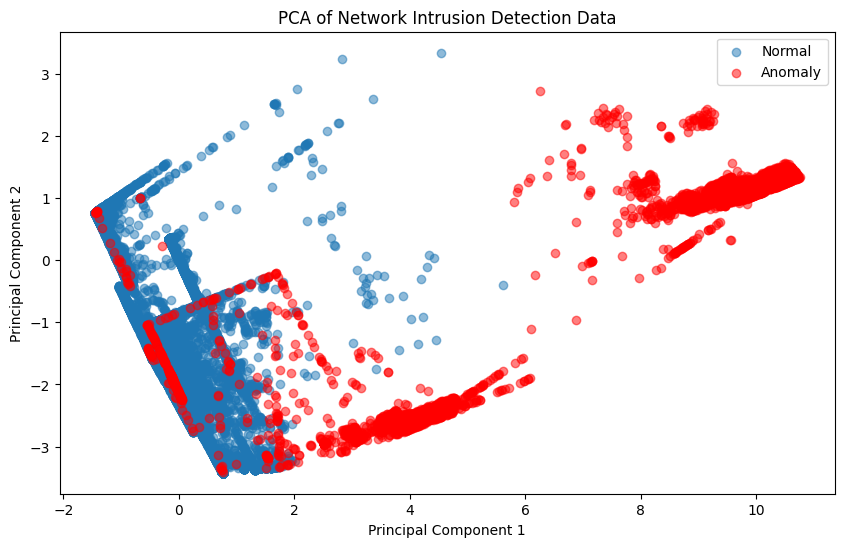

In [15]:
# 利用 PCA 進行降維，繪製降維後的數據分佈圖表，正常與異常連線以不同顏色標示出來
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# 將高維資料降至 2 維，方便在平面上視覺化
pca = PCA(n_components=2)
X_reduced = pca.fit_transform(X_train_scaled)

plt.figure(figsize=(10, 6))
plt.scatter(
  X_reduced[y_train == 0, 0], # 正常樣本的第一主成分
  X_reduced[y_train == 0, 1], # 正常樣本的第二主成分
  label='Normal', alpha=0.5
)
plt.scatter(
  X_reduced[y_train == 1, 0], # 異常樣本的第一主成分
  X_reduced[y_train == 1, 1], # 異常樣本的第二主成分
  label='Anomaly', alpha=0.5, color='r'
)
plt.title('PCA of Network Intrusion Detection Data')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()

### 3D PCA 視覺化補充

PCA 僅保留了資料的前兩個主要變異方向，可能損失部分資訊。

除了 2D 降維外，也可以用 3D PCA 進行更進一步的資料分佈觀察。

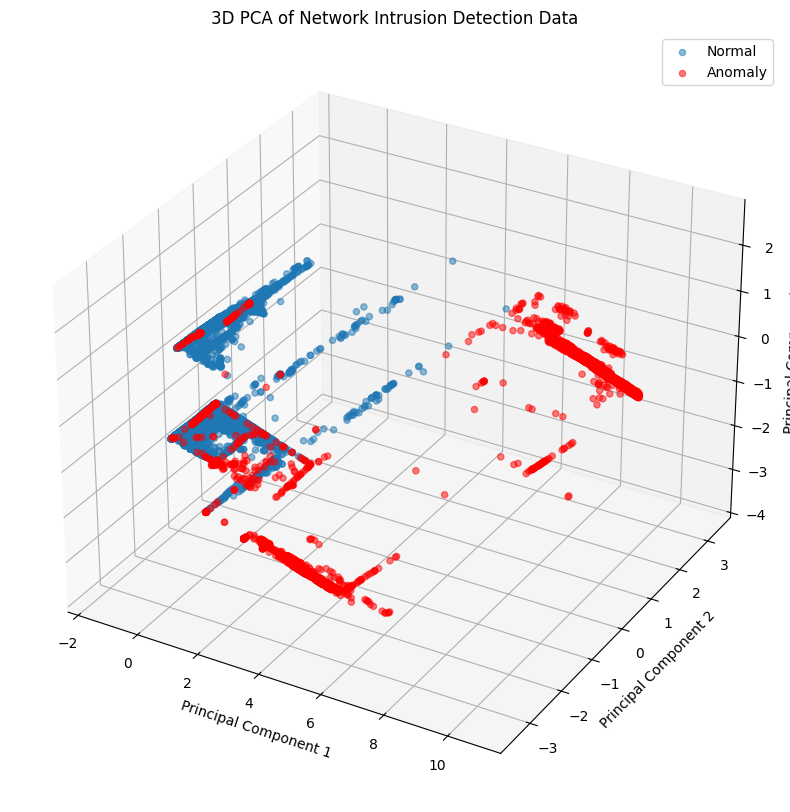

In [16]:
# 使用 3D PCA 繪製降維後的數據分佈圖表
from mpl_toolkits.mplot3d import Axes3D

# 將高維資料降至 3 維，方便在三維空間中視覺化
pca = PCA(n_components=3)
X_reduced_3d = pca.fit_transform(X_train_scaled)

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(
  X_reduced_3d[y_train == 0, 0],
  X_reduced_3d[y_train == 0, 1],
  X_reduced_3d[y_train == 0, 2],
  label='Normal', alpha=0.5
)
ax.scatter(
  X_reduced_3d[y_train == 1, 0],
  X_reduced_3d[y_train == 1, 1],
  X_reduced_3d[y_train == 1, 2],
  label='Anomaly', alpha=0.5, color='r'
)
ax.set_title('3D PCA of Network Intrusion Detection Data')
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
ax.legend()
plt.show()

---

## 5. 異常偵測模型訓練與評估

本單元將實作兩種我們學到的兩種異常偵測方法：
- **Isolation Forest**：基於隨機樹的無監督異常偵測。
- **AutoEncoder**：深度學習自編碼器，能捕捉複雜非線性結構。

每種方法皆會：
- 訓練模型
- 在測試集預測異常
- 計算準確率、精確率、召回率、F1 分數等指標
- 解讀模型表現與適用場景

### Isolation Forest：隨機樹異常偵測

本步驟將訓練 Isolation Forest 並評估其在測試集上的異常偵測能力。

In [17]:
# 利用 IsolationForest 訓練異常檢測模型
from sklearn.ensemble import IsolationForest

iso_forest = IsolationForest(
  contamination=0.1,
  random_state=42
)

# 使用標準化後的數據進行訓練
iso_forest.fit(X_train_scaled)

# 在測試集上進行異常檢測
y_pred = iso_forest.predict(X_test_scaled)
# IsolationForest 的預測結果為 1（正常）和 -1（異常）
# 將預測結果轉換為 0（正常）和 1（異常）
y_pred = [0 if pred == 1 else 1 for pred in y_pred]

In [18]:
# 計算準確率、召回率和 F1 分數
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("\n=== 測試集異常檢測性能指標 ===")
# (正確預測的樣本數) / (總樣本數)
print(f"準確率: {accuracy:.4f}")
# (正確預測為異常的樣本數) / (所有預測為異常的樣本數)
print(f"精確率: {precision:.4f}")
# (正確預測為異常的樣本數) / (實際異常的樣本數)
print(f"召回率: {recall:.4f}")
# F1 = 2 × (精確率 × 召回率) / (精確率 + 召回率)
print(f"F1 分數: {f1:.4f}")



=== 測試集異常檢測性能指標 ===
準確率: 0.9762
精確率: 0.8789
召回率: 0.8798
F1 分數: 0.8794


### AutoEncoder：深度學習異常偵測

本步驟將利用 `pyod` 套件訓練 AutoEncoder 並評估其異常偵測表現。

In [19]:
# 利用 AutoEncoder 訓練異常檢測模型
from pyod.models.auto_encoder import AutoEncoder

# 建立 AutoEncoder 模型
model = AutoEncoder(
  # 編碼器與解碼器結構：
  # 前兩個數字 (8, 4) 為編碼器逐層縮減神經元，
  # 後兩個數字 (4, 8) 為解碼器逐層還原，形成對稱的瓶頸架構。
  hidden_neuron_list=[8, 4, 4, 8],
  # 訓練參數
  epoch_num=30,
  batch_size=32,
  # 異常比例設定
  contamination=0.1,
  # 訓練過程不顯示詳細資訊
  verbose=0
)

# 使用標準化後的數據進行訓練，依機器效能需時約五分鐘
model.fit(X_train_scaled)

# 在測試集上進行異常檢測
y_pred = model.predict(X_test_scaled)

In [20]:
# 計算準確率、召回率和 F1 分數
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("\n=== 測試集異常檢測性能指標 ===")
print(f"準確率: {accuracy:.4f}")
print(f"精確率: {precision:.4f}")
print(f"召回率: {recall:.4f}")
print(f"F1 分數: {f1:.4f}")


=== 測試集異常檢測性能指標 ===
準確率: 0.9936
精確率: 0.9723
召回率: 0.9625
F1 分數: 0.9674
